# Sentiment Analysis with PyTorch and Sentence Transformers

In [9]:
# ------------------
# 2. Import Libraries
# ------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [10]:
# ------------------
# 3. Load Dataset
# ------------------
# We'll use the Sentiment140 dataset which contains 1.6 million tweets classified as negative or positive.
# Labels: 0 = negative, 4 = positive

tweets = pd.read_csv("sentiment_dataset.csv", encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])
tweets.drop(['ids','date','flag','user'], axis=1, inplace=True)
tweets['target'] = tweets['target'].replace(4,1)

print(tweets.tail())

# Split into train, validation, test
train_tweets, test_tweets = train_test_split(tweets, test_size=0.2, random_state=42)

print(train_tweets.shape, test_tweets.shape)

         target                                               text
1599995       1  Just woke up. Having no school is the best fee...
1599996       1  TheWDB.com - Very cool to hear old Walt interv...
1599997       1  Are you ready for your MoJo Makeover? Ask me f...
1599998       1  Happy 38th Birthday to my boo of alll time!!! ...
1599999       1  happy #charitytuesday @theNSPCC @SparksCharity...
(1280000, 2) (320000, 2)


In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe["text"]
        self.labels = dataframe["target"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        return text, label

train_dataset = CustomDataset(train_tweets)
test_dataset = CustomDataset(test_tweets)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [12]:
# ------------------
# 4. Sentence Transformer Model for Embeddings
# ------------------
# We'll use a pre-trained sentence transformer (distiluse-base-multilingual-cased-v2 ).
# This model converts sentences into numerical embeddings that capture semantic meaning.

hf_token = ""

embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2", token=hf_token)
embedding_model.eval()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [13]:
# ------------------
# 6. Classifier Model
# ------------------
# We'll define a simple feed-forward neural network classifier.
# Input size = embedding dimension (from Sentence Transformer)
# Output size = 3 (negative, neutral, positive)

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# ------------------
# 7. Training Setup
# ------------------

# Get embedding size
sample_embedding = embedding_model.encode("This is a test", convert_to_tensor=True)
input_dim = sample_embedding.shape[0]

model = SentimentClassifier(input_dim=input_dim, hidden_dim=64, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [15]:
# ------------------
# 7. Training Loop
# ------------------
num_epochs = 1
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for texts, labels in tqdm(train_loader):
        embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone().detach().to(device)
        labels = labels.to(device)

        outputs = model(embeddings)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)   # batch size

        train_losses.append(total_loss / total)
        train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone().detach().to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)   # batch size

            val_losses.append(val_loss / val_total)
            val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Train Acc {train_accs[-1]:.4f}, Val Loss {val_losses[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.0020, Train Acc 0.7543, Val Loss 0.0019, Val Acc 0.7664


In [20]:
# ------------------
# 9. Test Evaluation
# ------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for texts, labels in tqdm(test_loader):
        embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone().detach().to(device)
        labels = torch.tensor(labels).to(device)


        outputs = model(embeddings)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative","Positive"]))

  0%|          | 0/1250 [00:00<?, ?it/s]

/tmp/ipython-input-640651343.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.77    159494
    Positive       0.77      0.76      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



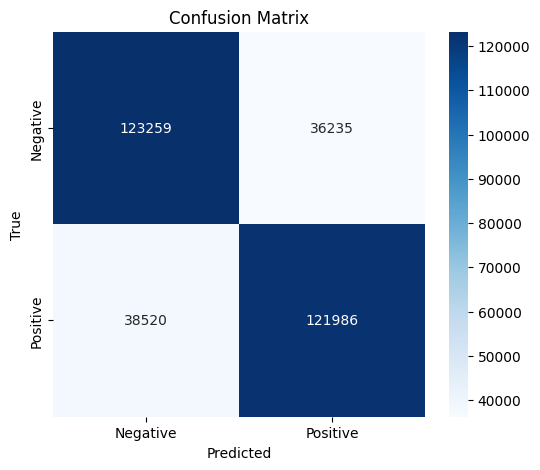

In [21]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# ------------------
# 11. Quick Test on Some Examples
# ------------------
# This small snippet takes a few examples from the test dataset,
# runs them through the classifier, and prints the text, predicted label, and true label.
import random

model.eval()
with torch.no_grad():
  for i in range(10):
    idx = random.randint(0, len(test_dataset))
    text, true_label = test_dataset[idx]
    embedding = embedding_model.encode([text], convert_to_tensor=True).clone().detach().to(device)
    output = model(embedding)
    _, pred_label = torch.max(output, 1)
    label_map = {0: "Negative", 1: "Positive"}
    print(f"Text: {text}")
    print(f"Predicted: {label_map[pred_label.item()]}")
    print(f"True: {label_map[true_label]}\n")

Text: @akaha00 you should get it &amp; tell me what you think. LOL I do that all the time with sims 2, and imagine if that happens in real life.hmm 
Predicted: Positive
True: Positive

Text: is tired and excited for tomorrow??! haha.. bukas na first day qh sa college... ARGH! haha  http://plurk.com/p/110zne
Predicted: Positive
True: Positive

Text: STILL awake! lol Just got done a long as night at work!! BORING  i was wishing i was with my girliess-next weekend im getting FUCKED up!!!
Predicted: Negative
True: Negative

Text: Realized how good extra sleep actually feels. 
Predicted: Negative
True: Positive

Text: @CullenHouse thats was the worst bit i read in the WHOLE saga... it made my heart sink!!  do some happy NM quotes 
Predicted: Negative
True: Positive

Text: is having a cup of hot coffee.. hmm yummyyy 
Predicted: Positive
True: Positive

Text: @funimation the video keeps erroring out for me after the commercial plays. 
Predicted: Negative
True: Negative

Text:  The Final Desti